In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

# Preparing Dataset

In [5]:
class InvalidDatasetException(Exception):
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

In [7]:
class AnimalDataset(Dataset):
    
    def __init__(self,img_paths,img_labels,size_of_images):
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.size_of_images = size_of_images
        if len(self.img_paths) != len(self.img_labels):
            raise InvalidDatasetException(self.img_paths,self.img_labels)
        
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self,index):
        PIL_IMAGE = Image.open(self.img_paths[index]).resize(self.size_of_images)
        TENSOR_IMAGE = transform(PIL_IMAGE)
        label = self.img_labels[index]
        
        return TENSOR_IMAGE,label

In [8]:
paths = []
labels = []
label_map = {0:"Cat",
             1:"Dog",
             2:"Wild"
            }

for cat_path in glob("../input/animal-faces/afhq/train/cat/*") + glob("../input/animal-faces/afhq/val/cat/*"):
    paths.append(cat_path)
    labels.append(0)
    
for dog_path in glob("../input/animal-faces/afhq/train/dog/*") + glob("../input/animal-faces/afhq/val/dog/*"):
    paths.append(dog_path)
    labels.append(1)
    
for wild_path in glob("../input/animal-faces/afhq/train/wild/*") + glob("../input/animal-faces/afhq/val/wild/*"):
    paths.append(wild_path)
    labels.append(2)
    
print(len(paths))
print(len(labels))

16130
16130


In [9]:
dataset = AnimalDataset(paths,labels,(250,250))

### 2. Preparing Sampler Objects

In [10]:
from sklearn.model_selection import train_test_split

dataset_indices = list(range(0,len(dataset)))

train_indices,test_indices = train_test_split(dataset_indices,test_size=0.2,random_state=42)
print("Number of train samples: ",len(train_indices))
print("Number of test samples: ",len(test_indices))

Number of train samples:  12904
Number of test samples:  3226


In [11]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

### 3. Preparing Data Loader Objects

In [12]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=test_sampler)

In [13]:
dataset[1][0].shape

torch.Size([3, 250, 250])

In [14]:
images,labels = next(iter(train_loader))
type(labels)

torch.Tensor

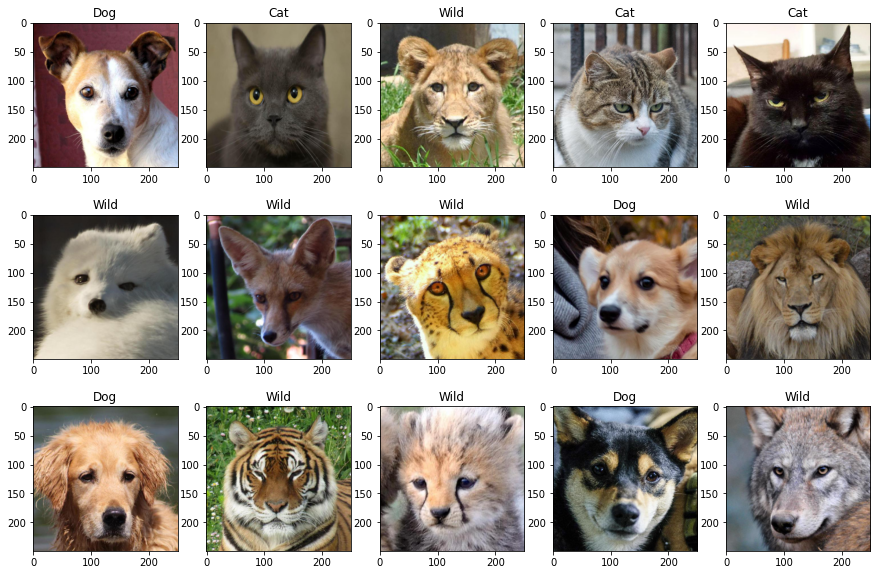

In [15]:
images,labels = iter(train_loader).next()

fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        npimg = images[i].numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        label = label_map[int(labels[i])]
        ax.imshow(npimg)
        ax.set(title = f"{label}")
        

# Neural Network Modeling

In [16]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        # First we'll define our layers
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,stride=2,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(256)
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(256 * 2 * 2,512)
        self.fc2 = nn.Linear(512,3)
        
    
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        x = F.relu(self.conv4(x))
        x = self.batchnorm3(x)
        x = self.maxpool(x)
        x = x.view(-1, 256 * 2 * 2)
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(x,dim=1)
        return x
        
        

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cpu')

In [19]:
model = CNN().to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(),lr=1e-4)

# Training Model

In [21]:
EPOCH_NUMBER = 5
TRAIN_LOSS = []
TRAIN_ACCURACY = []

for epoch in range(1,EPOCH_NUMBER+1):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for data_,target_ in train_loader:
        # We have to one hot encode our labels.
        target_ =target_.to(device)
        data_ = data_.to(device)
        
        # Cleaning the cached gradients if there are
        optimizer.zero_grad()
        
        # Getting train decisions and computing loss.
        outputs = model(data_)
        loss = criterion(outputs,target_)
        
        # Backpropagation and optimizing.
        loss.backward()
        optimizer.step()
        
        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        correct = correct + torch.sum(pred == target_).item()
        total += target_.size(0)
    
    # Appending stats to the lists.
    TRAIN_LOSS.append(epoch_loss)
    TRAIN_ACCURACY.append(100 * correct / total)
    print(f"Epoch {epoch}: Accuracy: {100 * correct/total}, Loss: {epoch_loss}")
        

Epoch 1: Accuracy: 84.58617482951023, Loss: 44.8067807033658
Epoch 2: Accuracy: 95.85399876007439, Loss: 12.455018483102322
Epoch 3: Accuracy: 98.27960322380657, Loss: 5.984365746378899
Epoch 4: Accuracy: 99.51952882827031, Loss: 2.5103362780064344
Epoch 5: Accuracy: 99.90700557966522, Loss: 0.9948955184081569


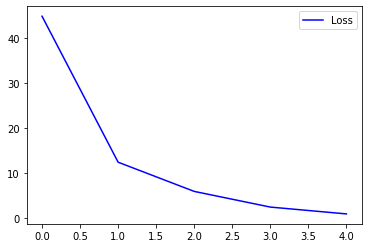

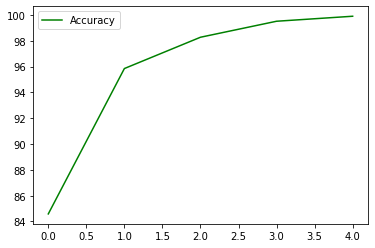

In [22]:
plt.subplots(figsize=(6,4))
plt.plot(range(EPOCH_NUMBER),TRAIN_LOSS,color="blue",label="Loss")
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(range(EPOCH_NUMBER),TRAIN_ACCURACY,color="green",label="Accuracy")
plt.legend()
plt.show()

# Final Test

In [23]:
total_val_loss = 0.0
total_true = 0
total = len(test_sampler)

# When we're not working with gradients and backpropagation
# we use torch.no_grad() utility.
with torch.no_grad():
    model.eval()
    for data_,target_ in validation_loader:
        data_ = data_.to(device)
        target_ = target_.to(device)
        
        outputs = model(data_)
        loss = criterion(outputs,target_).item()
        _,preds = torch.max(outputs,dim=1)
        total_val_loss += loss
        true = torch.sum(preds == target_).item()
        total_true += true

validation_accuracy = round(100 * total_true / total,2)
print(f"Validation accuracy: {validation_accuracy}%")
print(f"Validation loss: {round(total_val_loss,2)}%")

Validation accuracy: 95.94%
Validation loss: 2.87%


# How to Save A Pytorch Model

In [24]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

conv1.weight 	 torch.Size([32, 3, 3, 3])
conv1.bias 	 torch.Size([32])
conv2.weight 	 torch.Size([64, 32, 3, 3])
conv2.bias 	 torch.Size([64])
batchnorm1.weight 	 torch.Size([64])
batchnorm1.bias 	 torch.Size([64])
batchnorm1.running_mean 	 torch.Size([64])
batchnorm1.running_var 	 torch.Size([64])
batchnorm1.num_batches_tracked 	 torch.Size([])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
batchnorm2.weight 	 torch.Size([128])
batchnorm2.bias 	 torch.Size([128])
batchnorm2.running_mean 	 torch.Size([128])
batchnorm2.running_var 	 torch.Size([128])
batchnorm2.num_batches_tracked 	 torch.Size([])
conv4.weight 	 torch.Size([256, 128, 3, 3])
conv4.bias 	 torch.Size([256])
batchnorm3.weight 	 torch.Size([256])
batchnorm3.bias 	 torch.Size([256])
batchnorm3.running_mean 	 torch.Size([256])
batchnorm3.running_var 	 torch.Size([256])
batchnorm3.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([512, 1024])
fc1.bias 	 torch.Size([512])
fc2.weight 	 torch.

* save and load this state dict.

In [25]:
torch.save(model.state_dict(),"model.pt")


* create a new object from the class and load the state dict.

In [26]:
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("model.pt"))


<All keys matched successfully>